In [1]:
import cv2
import numpy as np
import openvino as ov
import matplotlib.pyplot as plt
from notebook_utils import segmentation_map_to_image

In [2]:
core = ov.Core()

In [50]:
colormap = np.array([[0, 0, 0], [51, 255, 119], [53, 183, 120], [86, 210, 245]])

In [4]:
colormap.shape

(4, 3)

In [5]:
model = core.read_model(model='./models/road-segmentation-adas-0001.xml')

In [6]:
compiled_model = core.compile_model(model=model, device_name='CPU')
input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)
N, C, H, W = input_layer_ir.shape

In [7]:
input_layer_ir

<ConstOutput: names[data] shape[1,3,512,896] type: f32>

In [8]:
output_layer_ir

<ConstOutput: names[L0317_ReWeight_SoftMax, L0317_ReWeight] shape[1,4,512,896] type: f32>

In [9]:
def resize(mask):
    # Resize the array to match the height of the target shape (1280, 720)
    resized_array = cv2.resize(mask, (1280, 720), interpolation=cv2.INTER_LINEAR)
    return resized_array

In [40]:
def plot_multiple_arrays(masks, masks_titles):
    fig, axs = plt.subplots(1, len(masks), figsize=(15, 5))

    for i, (mask, title) in enumerate(zip(masks, masks_titles)):
        axs[i].imshow(cv2.cvtColor(mask, cv2.COLOR_BGR2RGB))
        axs[i].set_title(f"{title} mask")
        axs[i].axis('off')

    plt.tight_layout()
    plt.show()

In [11]:
def preprocess(frame, H, W):
    """
    Preprocess the frame for openvino model.
    """
    image_bgr = cv2.cvtColor(frame, cv2.COLOR_RGB2BGR)
    resized_image = cv2.resize(image_bgr, (W, H))
    # Reshape to the network input shape.
    input_image = np.expand_dims(
        resized_image.transpose(2, 0, 1), 0
    )  
    return input_image

In [12]:
img = cv2.imread('./data/d3f34243-a7166713.jpg')

# Preprocess the frame
height, width, _ = img.shape
input_image = preprocess(img, H, W)

In [13]:
# Perform inference
result = compiled_model([input_image])[output_layer_ir]

## Mask 1 
someone's else way to get the mask

In [14]:
segmentation_mask = np.argmax(result, axis=1)
segmentation_mask.shape

(1, 512, 896)

In [42]:
mask1 = segmentation_map_to_image(segmentation_mask, colormap)
alpha = 0.4

overlay = img.copy()
mask1 = resize(mask1)

# Add the segmentation mask to the overlay with transparency
segmented_mask1 = cv2.addWeighted(mask1, alpha, overlay, 1-alpha, 0, overlay)

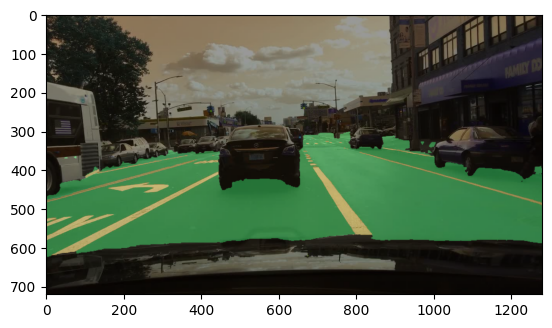

In [43]:
plt.imshow(segmented_mask1)

In [17]:
# Save the image
success = cv2.imwrite('mask1.png', segmented_mask1)
if not success:
    print("Error: Image not saved")

## Mask 2
my way to get the mask

In [51]:
# Divide the mask into four equal parts along the first axis
parts = np.split(result, 4, axis=1)

# Select the road mask and curbs parts
bg = parts[0].reshape((512,896,1))
road = parts[1].reshape((512,896,1))
marks = parts[2].reshape((512,896,1))
curbs = parts[3].reshape((512,896,1))

In [52]:
bg.shape

(512, 896, 1)

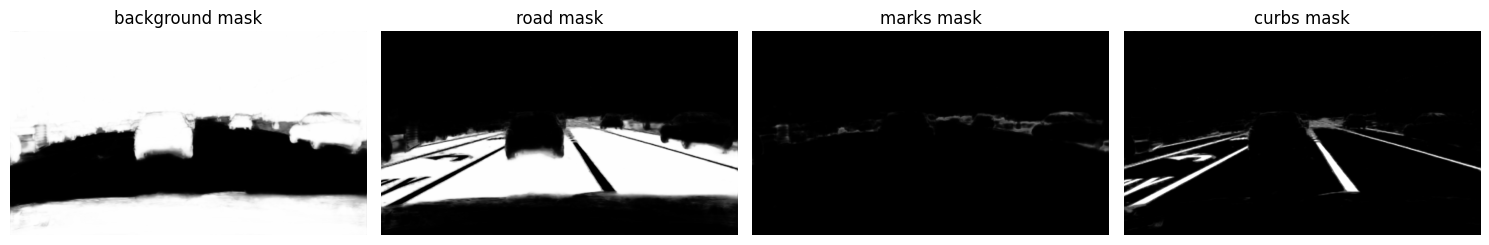

In [53]:
masks_titles = ['background', 'road', 'marks', 'curbs']
masks = [bg, road, marks, curbs]
plot_multiple_arrays(masks, masks_titles)

In [54]:
# Rescale the values to the range [0, 255]
bg_white_mask = bg * [255, 255, 255]
road_white_mask = road * [255, 255, 255]
curbs_white_mask = curbs * [255, 255, 255]
marks_white_mask = marks * [255, 255, 255]
road_colored_mask = road * colormap[1]
marks_colored_mask = marks * colormap[2]
curbs_colored_mask = curbs * colormap[3]

In [55]:
# Change type of np array to avoid errors later
bg_white_mask = bg_white_mask.astype('uint8')
road_colored_mask = road_colored_mask.astype('uint8')
marks_colored_mask = marks_colored_mask.astype('uint8')
curbs_colored_mask = curbs_colored_mask.astype('uint8')
road_white_mask = road_white_mask.astype('uint8')
marks_white_mask = marks_white_mask.astype('uint8')
curbs_white_mask= curbs_white_mask.astype('uint8')

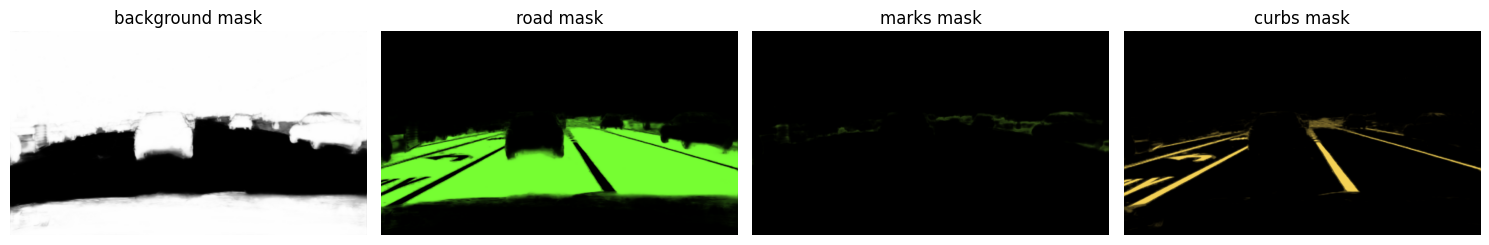

In [56]:
masks_titles = ['background', 'road', 'marks', 'curbs']
masks = [bg_white_mask, road_colored_mask, marks_colored_mask, curbs_colored_mask]
plot_multiple_arrays(masks, masks_titles)


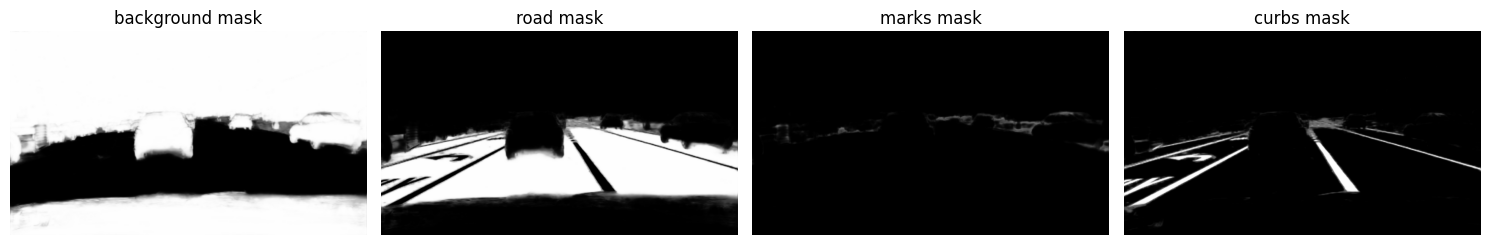

In [57]:
masks_titles = ['background', 'road', 'marks', 'curbs']
masks = [bg_white_mask, road_white_mask, marks_white_mask, curbs_white_mask]

plot_multiple_arrays(masks, masks_titles)

In [58]:
# Resize to original image width and height
bg_white_mask = resize(bg_white_mask)
road_white_mask = resize(road_white_mask)
marks_white_mask = resize(marks_white_mask)
curbs_white_mask= resize(curbs_white_mask)
road_colored_mask = resize(road_colored_mask)
marks_colored_mask = resize(road_colored_mask)
curbs_colored_mask = resize(curbs_colored_mask)


In [59]:
marks_white_mask.shape

(720, 1280, 3)

In [60]:
colored_mask = road_colored_mask + curbs_colored_mask
white_mask = road_white_mask + curbs_white_mask + marks_white_mask

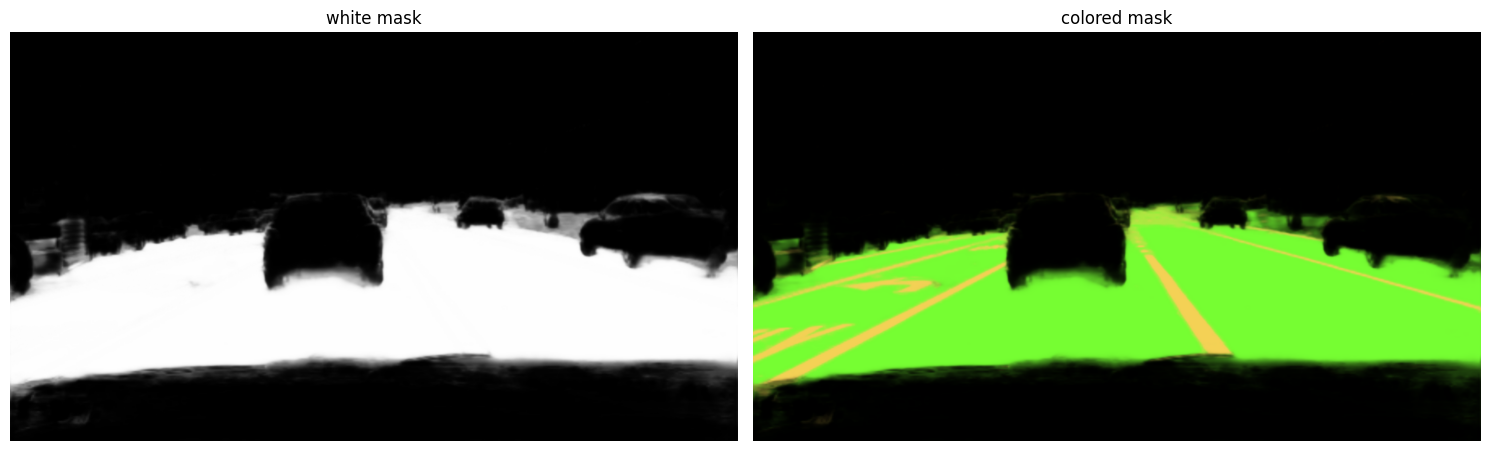

In [61]:
masks_titles = ['white', 'colored']
masks = [white_mask, colored_mask]
plot_multiple_arrays(masks, masks_titles)

In [62]:
img.dtype, bg_white_mask.dtype

(dtype('uint8'), dtype('uint8'))

In [63]:
img.shape, bg_white_mask.shape

((720, 1280, 3), (720, 1280, 3))

Bitwise AND on background and mask

In [64]:
subtracted_road=cv2.bitwise_and(img, bg_white_mask,mask=None)

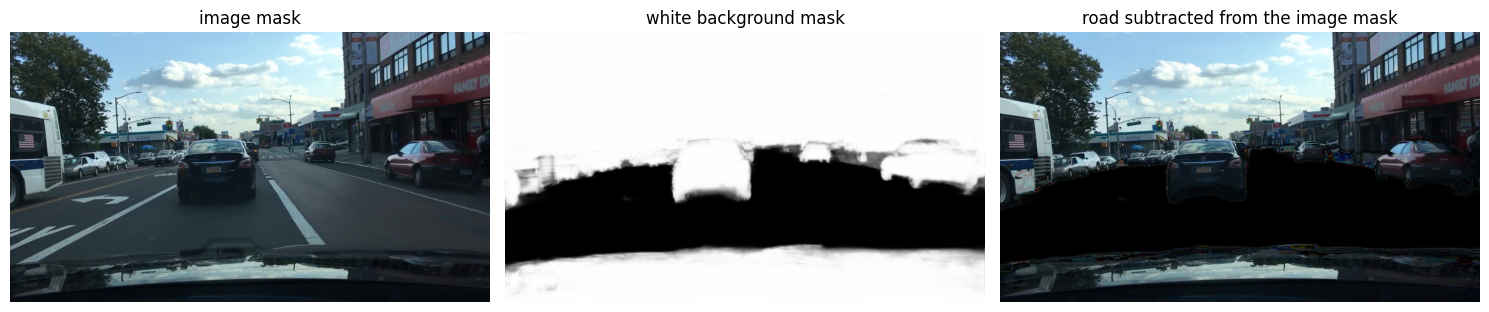

In [65]:
masks_titles = ['image', 'white background', 'road subtracted from the image']
masks = [img, bg_white_mask, subtracted_road]
plot_multiple_arrays(masks, masks_titles)

Bitwise AND on road and mask

In [66]:
segmented_road=cv2.bitwise_and(img, white_mask,mask=None)

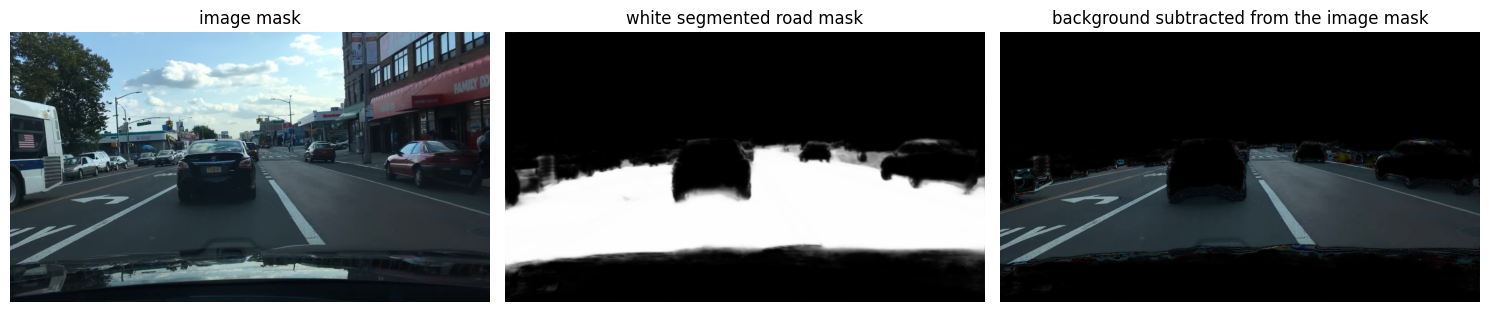

In [67]:
masks_titles = ['image', 'white segmented road', 'background subtracted from the image']
masks = [img, white_mask, segmented_road]
plot_multiple_arrays(masks, masks_titles)

Overlay the road with colored mask

In [68]:
alpha = .7
overlay = segmented_road.copy()
segmented_image = cv2.addWeighted(colored_mask, alpha, overlay, 1-alpha, 0, overlay)

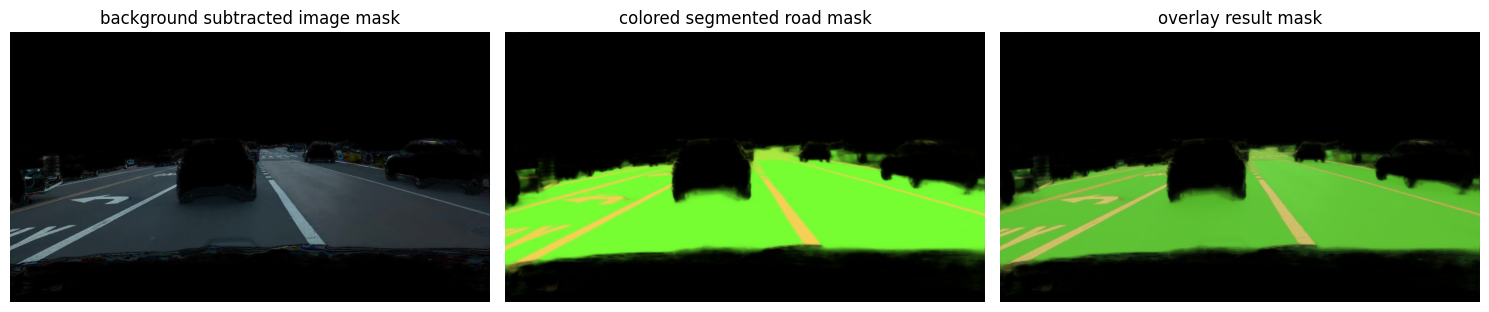

In [69]:
masks_titles = ['background subtracted image', 'colored segmented road', 'overlay result']
masks = [segmented_road, colored_mask, segmented_image]
plot_multiple_arrays(masks, masks_titles)

Bitwise OR on overlayed mask and background

In [70]:
final_result=cv2.bitwise_or(subtracted_road,segmented_image,mask=None)

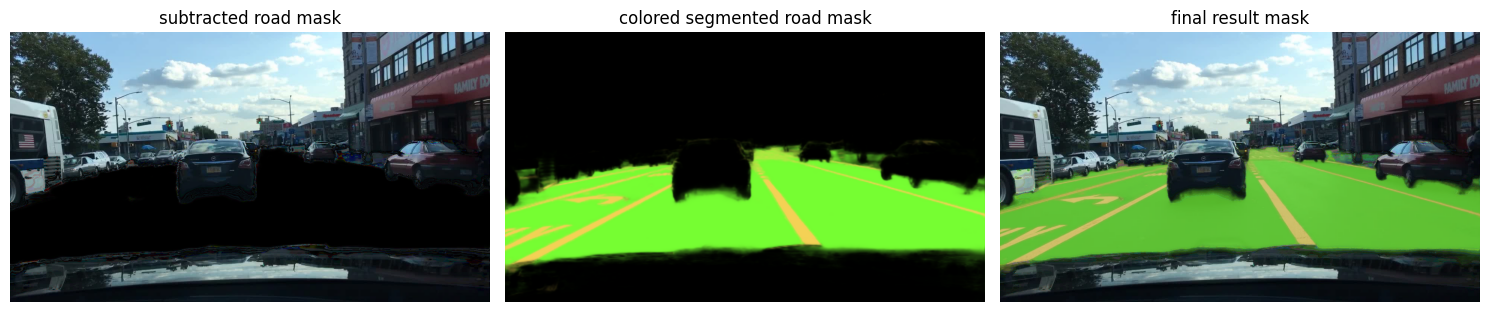

In [71]:
masks_titles = ['subtracted road', 'colored segmented road', 'final result']
masks = [subtracted_road, colored_mask, final_result]
plot_multiple_arrays(masks, masks_titles)

In [72]:
# Save the image
success = cv2.imwrite('mask2.png', final_result)
if not success:
    print("Error: Image not saved")